# Import modules

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, RobustScaler

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

sns.set(
    {"figure.figsize": (17, 7)},
    style="ticks",
    palette=sns.color_palette("Set2"),
    color_codes=True,
    font_scale=0.8
)

%config InlineBackend.figure_format = "retina"

import warnings
warnings.filterwarnings("ignore")

# Load data

In [3]:
# Load the dataset
auto = pd.read_csv("adverts.csv")

In [4]:
auto = auto.sample(1000)

In [5]:
seed = 42

# Identify erroneous data

### Price

In [6]:
# Drop rows with unrealistic prices
auto = auto.loc[auto["price"] != 9999999]

### Mileage

In [7]:
# Very low mileage is likely erroneous for older used cars
auto.loc[
    (auto["mileage"] <= 100) & 
    (auto["vehicle_condition"] == "USED") & 
    (auto["year_of_registration"] < 2018), 
    "mileage"] = np.nan

### Year of reg

In [8]:
# Set the years of reg for new cars to 2020
auto.loc[(auto["vehicle_condition"]=="NEW") & (auto["year_of_registration"].isna()), "year_of_registration"] = 2020

In [9]:
# Remove very old years for non-old makes
# Note for me: "~"" means not
auto.loc[(auto["year_of_registration"] < 1950) & (~auto["standard_make"].isin(["Austin", "Morris"])), "year_of_registration"] = np.nan

### Reg code

In [10]:
class RegCodeToYear(BaseEstimator, TransformerMixin):
    '''
    Converts reg codes into years based on the letter or number.
    For letter codes there are two possible corresponding years,
    so both years are saved as a tuple.  
    '''
    def __init__(self, column="reg_code", target_column="reg_code_year"):
        self.column = column
        self.target_column = target_column

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()

        if not(self.column in X):
            print("Skipping reg code to year as no reg code column is present.")
            return X
        
        def reg_to_year(reg_code):
            try:
                reg_code = int(reg_code)
                if reg_code > 71 or (50 > reg_code > 20): return np.nan
                return 2000 + reg_code % 50
            except (ValueError, TypeError):
                if not isinstance(reg_code, str): return np.nan
                letters = "ABCDEFGHJKLMNPRSTXY"
                if reg_code == "V": return (1979, 1999)
                if reg_code == "W": return (1980, 2000)
                if reg_code not in letters: return np.nan
                return (1983 + letters.find(reg_code), 1963 + letters.find(reg_code))

        # Apply the reg_to_year function and create the target column
        X[self.target_column] = X[self.column].map(reg_to_year)
        return X

In [11]:
class RegYearDisambiguator(BaseEstimator, TransformerMixin):
    '''
    Some letter reg codes can match to two different years e.g. "A" maps to both 1963 and 1983.
    This transformer finds the mean year of other cars of the same model and picks whichever of
    the two is closer to that mean. If there are no matching models of car the most recent year
    is taken as newer cars are more common in the dataset.
    '''
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        if not("reg_code" in X or "year_of_registration" in X or "reg_code_year" in X):
            print("Skipping reg year disambiguation as year is not present")
            return X
        
        def is_alpha(val):
            try: return not val.isnumeric()
            except: return False
            
        missing = X[(X["reg_code"].apply(is_alpha)) & (X["year_of_registration"].isna())]

        # For each ambiguous year select the year closest to the mean for that make.
        missing = missing.loc[missing["reg_code_year"].notna()]
        full_missing = X.loc[missing.index]

        for i in range(len(full_missing)):
            missing_model = full_missing.iloc[i]["standard_model"]
            years = full_missing.iloc[i]["reg_code_year"]
            used = X.loc[(X["standard_model"] == missing_model) & (X["year_of_registration"].notna())]

            mean_year = np.array(used["year_of_registration"]).mean()
            closest_year = years[0] if abs(mean_year - years[0]) < abs(mean_year - years[1]) else years[1]

            X.at[missing.index[i], "reg_code_year"] = closest_year

        return X

In [12]:
class FillYearWithReg(BaseEstimator, TransformerMixin):
    ''' Fill in missing year_of_registrations with the parsed data from the reg code.'''
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        if not("reg_code" in X or "year_of_registration" in X or "reg_code_year" in X):
            print("Skipping fill year with reg as columns are not present.")
            return X

        # Copy the year from the reg code for missing years then drop reg code and reg code year
        X.loc[auto["year_of_registration"].isna(), "year_of_registration"] = X["reg_code_year"]

        X.drop(columns=["reg_code", "reg_code_year"], inplace=True)
        
        return X

# Process data for model

In [13]:
class AutoEncodeBinary(BaseEstimator, TransformerMixin):
    ''' Find non numeric features with only two values and replace them with 0 and 1'''
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()

        for col in X:
            if isinstance(col, (str, bool))  and len(X[col].unique()) == 2:
                X[col] = X[col].replace({X[col].unique()[0]:0, X[col].unique()[1]:1})

        return X

In [14]:
class ParseReference(BaseEstimator, TransformerMixin):
    """ Extract date (in days) from public reference and then drop the column. """
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        if not "public_reference" in X:
            print("Skipping ParseReference as no public reference found in frame.")
            return X

        time = pd.DataFrame()
        time["year"] = X["public_reference"].astype(str).str[:4].astype(int)
        time["month"] = X["public_reference"].astype(str).str[4:6].astype(int)
        time["day"] = X["public_reference"].astype(str).str[6:8].astype(int)
        X["public_reference"] = round(time["year"]*365.25 + time["month"]*30.436875 + time["day"]).astype(int)
        X = X.rename(columns={"public_reference": "reference"})

        return X

In [15]:
class CombineMakeModel(BaseEstimator, TransformerMixin):
    '''Combine the makes and models into a single feature.'''
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Combine make and model into one column
        X = pd.DataFrame(X, columns=["standard_colour", "standard_make", "standard_model", "vehicle_condition", "body_type", "crossover_car_and_van", "fuel_type"])
        X["make_model"] = X["standard_make"] + " " + X["standard_model"]
        X.drop(columns=["standard_make", "standard_model"], inplace=True)

        return X

In [16]:
class ImportanceImputer(BaseEstimator, TransformerMixin):
    '''
    Imputes categorical data by taking the mode of data which match other
    categorical features. The other categorical features are sorted based
    on their correlation with the target feature. To find the correlation
    Cramer's V is used. The imputer first attempts to locate entries that
    match every feature e.g. finding cars with the same make, model, year
    and condition. If no match is found, then the least important feature
    is ignored and the process continues until a minimum matching entries
    are found. Once found, the modes of the matches are filled in the gap.

    '''
    def __init__(self, impute_features, similar_threshold=5, bin_numeric=False, max_depth=2):
        self.impute_features = impute_features
        self.similar_threshold = similar_threshold
        self.bin_numeric = bin_numeric
        self.max_depth = max_depth

    def fit(self, X, y=None):
        X = X.copy()

        for feature in self.impute_features:
            # Identify numeric and categorical features
            self.numerical_features_ = list(set(X.select_dtypes(include=[np.number]).columns) - {feature})
            self.categorical_features_ = list(set(X.columns) - set(self.numerical_features_) - {feature})

            # Bin numeric features if specified
            self.binned_features_ = []
            if self.bin_numeric:
                for feat in self.numerical_features_:
                    paired_df = X[X[feature].notna()]
                    X_feat = paired_df[[feat]]
                    y_feat = paired_df[feature]

                    # Fit decision tree
                    tree = DecisionTreeClassifier(max_depth=self.max_depth, random_state=42)
                    tree.fit(X_feat, y_feat)

                    # Extract thresholds from tree
                    thresholds = []
                    def traverse_tree(node=0):
                        if tree.tree_.feature[node] != -2:  # Not a leaf node
                            thresholds.append(tree.tree_.threshold[node])
                            traverse_tree(tree.tree_.children_left[node])
                            traverse_tree(tree.tree_.children_right[node])
                    traverse_tree()

                    thresholds = sorted(thresholds)
                    bins = [-np.inf] + thresholds + [np.inf]
                    labels = [f"Bin_{i}" for i in range(len(bins) - 1)]

                    self.binned_features_.append((feat, bins, labels))
                    self.categorical_features_.append(f"{feat}_binned")

            # Compute Cramér"s V for categorical features
            self.cramer_dict_ = {}
            for feat in self.categorical_features_:
                contingency_table = pd.crosstab(X[feat], X[feature])
                chi2, _, _, _ = chi2_contingency(contingency_table)
                n = contingency_table.sum().sum()
                r, k = contingency_table.shape
                cramer_v = np.sqrt((chi2 / n) / (min(r, k) - 1))
                self.cramer_dict_[feat] = cramer_v

            self.cramer_dict_ = dict(sorted(self.cramer_dict_.items(), key=lambda x: -x[1]))
            self.ordered_features_ = list(self.cramer_dict_.keys())

        return self

    def transform(self, X):
        X = X.copy()

        for feature in self.impute_features:
            # Bin numeric features if specified
            if self.bin_numeric:
                for feat, bins, labels in self.binned_features_:
                    X[f"{feat}_binned"] = pd.cut(X[feat], bins=bins, labels=labels)

            # Impute missing values
            missing_indices = X[X[feature].isna()].index

            def impute_value(row):
                subset = self.ordered_features_[:]
                while subset:
                    condition = True
                    for feat in subset:
                        condition &= X[feat] == row[feat]
                    similar_entries = X.loc[condition & X[feature].notna()]

                    if len(similar_entries) >= self.similar_threshold:
                        return similar_entries[feature].mode()[0]
                    subset.pop()

                return X[feature].mode()[0]

            # Apply imputation
            X.loc[missing_indices, feature] = X.loc[missing_indices].apply(impute_value, axis=1)

            # Drop binned features if specified
            if self.bin_numeric:
                for feat, _, _ in self.binned_features_:
                    X.drop(columns=[f"{feat}_binned"], inplace=True)

        return X

# Split data

In [17]:
cat_features = ["standard_colour", "standard_make", "standard_model", "vehicle_condition", "body_type", "crossover_car_and_van", "fuel_type"]

general_process = Pipeline([
    ("r2y", RegCodeToYear()),
    ("ryd", RegYearDisambiguator()),
    ("fyr", FillYearWithReg()),
    ("aeb", AutoEncodeBinary()),
    ("par", ParseReference())
])
cat_pipe = Pipeline([
    ("imp", ImportanceImputer(impute_features=cat_features)),
    ("cmm", CombineMakeModel()),
    ("ohenc", OneHotEncoder(sparse_output=False, handle_unknown="ignore", dtype=int))
])
num_pipe = Pipeline([
    ("imp", KNNImputer()),
    ("scl", RobustScaler()),
    ("tsf", PowerTransformer())
])
col_transformer = ColumnTransformer(
    transformers=[
        ("num", num_pipe, ["reference", "mileage", "year_of_registration"]),
        ("cat", cat_pipe, cat_features),
    ])
preprocessor = Pipeline([
    ("gen", general_process),
    ("pre", col_transformer)
])

In [18]:
knn_pipeline = Pipeline([
    ("pp", preprocessor),
    ("knn", KNeighborsRegressor(5))
])

dtr_pipeline = Pipeline([
    ("pp", preprocessor),
    ("dtr", DecisionTreeRegressor())
])

lnr_pipeline = Pipeline([
    ("pp", preprocessor),
    ("lnr", LinearRegression())
])

knn_pipeline

Pipeline(steps=[('pp',
                 Pipeline(steps=[('gen',
                                  Pipeline(steps=[('r2y', RegCodeToYear()),
                                                  ('ryd',
                                                   RegYearDisambiguator()),
                                                  ('fyr', FillYearWithReg()),
                                                  ('aeb', AutoEncodeBinary()),
                                                  ('par', ParseReference())])),
                                 ('pre',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imp',
                                                                                    KNNImputer()),
                                                                                   ('scl',
                                                                                    RobustScaler()),
                                                                                   ('tsf',
                                                                                    PowerTransformer())]),
                                                                   ['reference',
                                                                    'mile...
                                                                                                                       'standard_model',
                                                                                                                       'vehicle_condition',
                                                                                                                       'body_type',
                                                                                                                       'crossover_car_and_van',
                                                                                                                       'fuel_type'])),
                                                                                   ('cmm',
                                                                                    CombineMakeModel()),
                                                                                   ('ohenc',
                                                                                    OneHotEncoder(dtype=<class 'int'>,
                                                                                                  handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['standard_colour',
                                                                    'standard_make',
                                                                    'standard_model',
                                                                    'vehicle_condition',
                                                                    'body_type',
                                                                    'crossover_car_and_van',
                                                                    'fuel_type'])]))])),
                ('knn', KNeighborsRegressor())])

In [19]:
X, y = auto.drop(columns="price"), auto[["price"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
reg_year_df = RegCodeToYear().fit_transform(X)

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,body_type,crossover_car_and_van,fuel_type,reg_code_year


In [21]:
# cross_val_score(knn_pipeline, X, y)
# array([0.49100901, 0.49820213, 0.42029762, 0.48937155, 0.54981242])
# array([0.5395643 , 0.50119664, 0.43458691, 0.49099346, 0.54934357])

In [22]:
# cross_val_score(dtr_pipeline, X, y)
# array([0.62553496, 0.65563623, 0.59411849, 0.74908345, 0.70266929])

In [23]:
# cross_val_score(lnr_pipeline, X, y)
# array([-4.41064499e+16, -1.36877205e+17, -1.28565821e+15, -4.05077216e+17, -5.05992851e+16])

In [24]:
# processed_data = pd.DataFrame(preprocessor.fit_transform(X, y))
# processed_price = pd.DataFrame(num_pipe.fit_transform(y, None))
# processed_data["price"] = processed_price
# processed_data = processed_data.convert_dtypes()
# processed_data.to_csv("processed_data.csv", index=False)
# processed_data

In [25]:
knn_pipeline.fit(X_train, y_train)
actual = y_test.to_numpy().ravel()
predicted = knn_pipeline.predict(X_test).ravel()

prediction_df = pd.DataFrame({'Actual': actual, 'Predicted': predicted})

In [72]:
prediction_df["Actual"] = prediction_df["Actual"]/1000
prediction_df["Predicted"] = prediction_df["Predicted"]/1000

In [75]:
plot_sample_size = 12

df_plot = prediction_df.sample(plot_sample_size, random_state=seed)

X_cars = X_test.reset_index(drop=True)[["year_of_registration", "standard_colour", "standard_make", "standard_model"]]
X_cars_sample = X_cars.loc[df_plot.index]
X_cars_sample["year_of_registration"] = X_cars_sample["year_of_registration"].astype(int)
X_cars_sample["name"] = X_cars_sample["year_of_registration"].astype(str) + " " +  X_cars_sample["standard_make"] + " " + X_cars_sample["standard_model"]

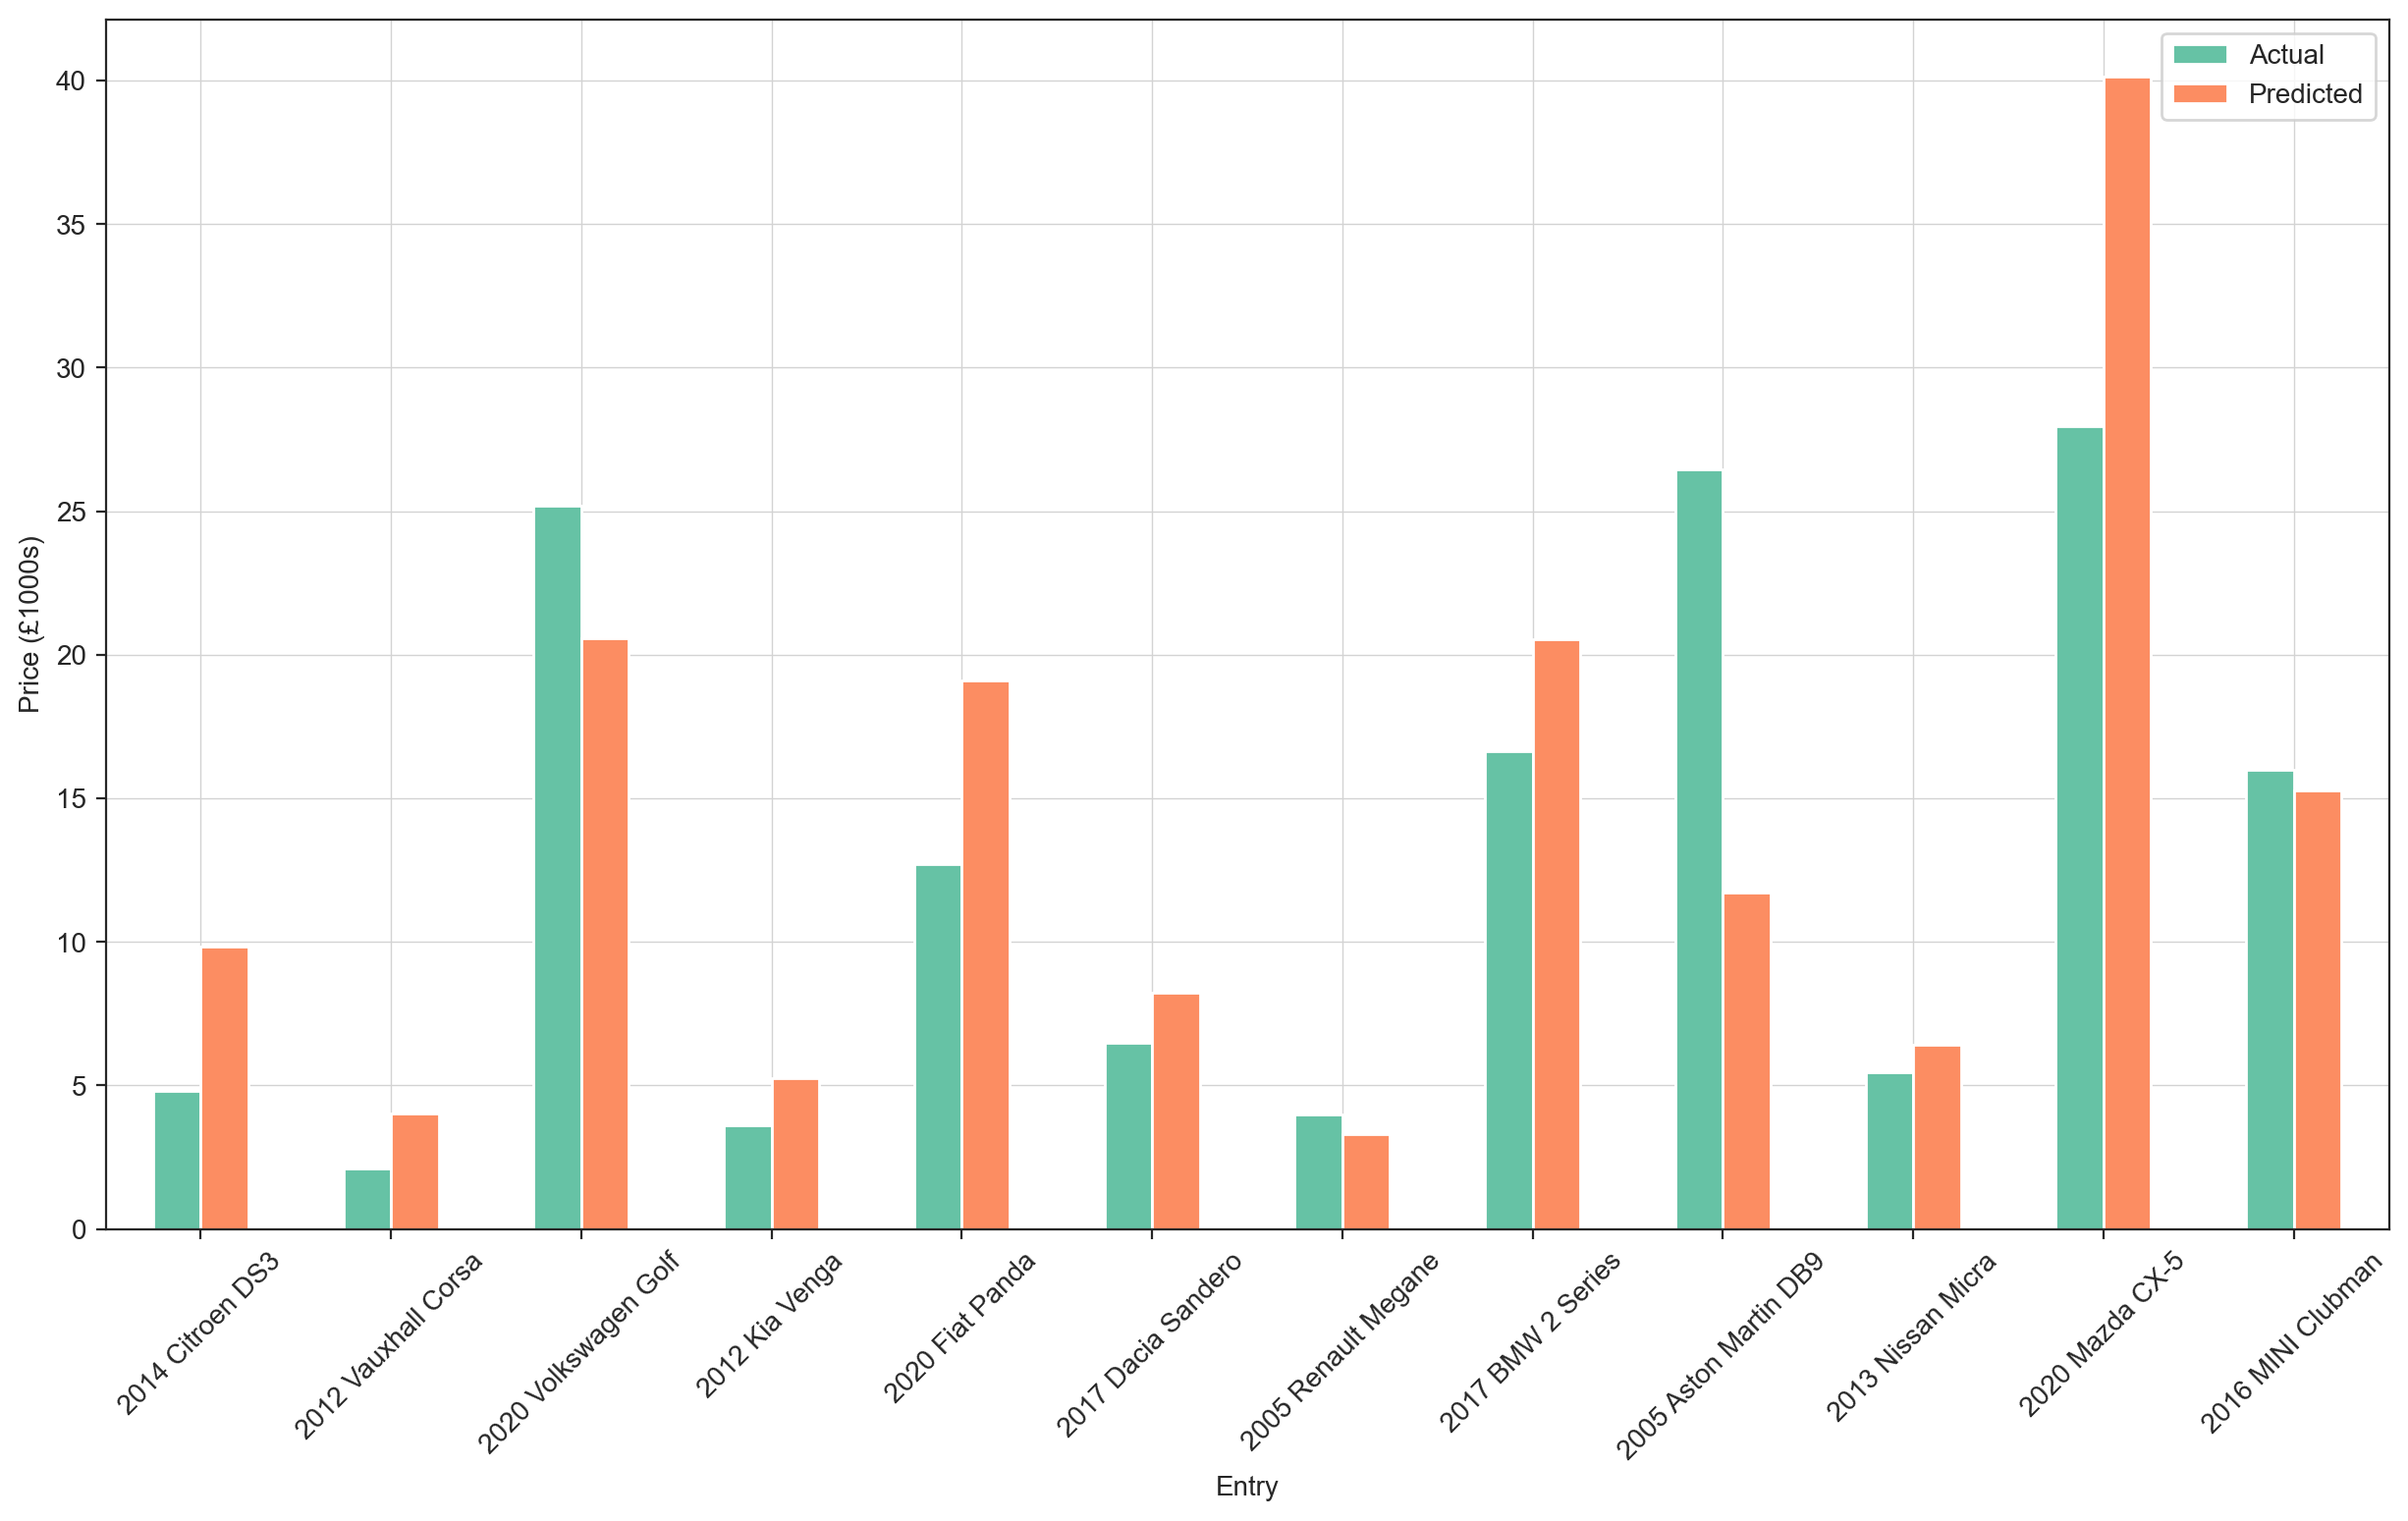

In [77]:
df_plot.plot(kind='bar',figsize=(15,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='lightgray')
plt.xticks(ticks=np.arange(0, plot_sample_size), labels=X_cars_sample["name"], rotation=45)
plt.ylabel("Price (£1000s)")
plt.xlabel("Entry");